In [199]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [200]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [201]:
NUM_CLASSES = 20

# Dataset reading

In [202]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [203]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [205]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [206]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 42)                0         
                                                                 
 dense_27 (Dense)            (None, 200)               8600      
                                                                 
 dropout_19 (Dropout)        (None, 200)               0         
                                                                 
 dense_28 (Dense)            (None, 100)               20100     
                                                                 
 dense_29 (Dense)            (None, 20)                2020      
                                                                 
Total params: 30,720
Trainable params: 30,720
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [208]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [209]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/14 [=>............................] - ETA: 2s - loss: 2.9887 - accuracy: 0.0469
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 11ms/step - loss: 2.7669 - accuracy: 0.1111 - val_loss: 2.4498 - val_accuracy: 0.1684
Epoch 2/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.5136 - accuracy: 0.1406
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 4ms/step - loss: 2.3404 - accuracy: 0.2370 - val_loss: 2.0315 - val_accuracy: 0.6054
Epoch 3/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.1523 - accuracy: 0.3906
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 3ms/step - loss: 1.9769 - accuracy: 0.4093 - val_loss: 1.6485 - val_accuracy: 0.5663
Epoch 4/1000
 1/14 [=>............................] - ETA: 0s - loss: 1.8124 - accuracy: 0.4453


In [210]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 1ms/step - loss: 0.0839 - accuracy: 0.9796


In [211]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [212]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[5.3147291e-05 1.8294141e-16 3.6176641e-02 7.8091131e-07 6.4334438e-10
 2.2823722e-13 3.8000414e-12 3.8523757e-15 1.1391560e-14 2.8083911e-15
 2.9302901e-12 7.9114178e-13 9.6376926e-01 9.6016660e-14 2.2751010e-13
 1.3746518e-07 2.2251307e-16 3.3662810e-14 1.1146932e-12 1.8096198e-15]
12


# Confusion matrix

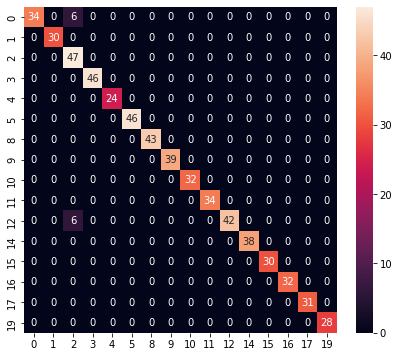

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        40
           1       1.00      1.00      1.00        30
           2       0.80      1.00      0.89        47
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        46
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        39
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        34
          12       1.00      0.88      0.93        48
          14       1.00      1.00      1.00        38
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00        32
          17       1.00      1.00      1.00        31
          19       1.00      1.00      1.00        28

    accuracy                           0.98       588
   m

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [214]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [215]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp2w0o2s9z/assets


INFO:tensorflow:Assets written to: /tmp/tmp2w0o2s9z/assets
2023-01-06 18:25:27.030271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-01-06 18:25:27.030305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-01-06 18:25:27.030417: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp2w0o2s9z
2023-01-06 18:25:27.031298: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-01-06 18:25:27.031312: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp2w0o2s9z
2023-01-06 18:25:27.034645: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-01-06 18:25:27.060188: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp2w0o2s9z
2023-01-06 18:25:27.068361: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

33808

# Inference test

In [216]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [217]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [218]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [219]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 604 µs, sys: 49 µs, total: 653 µs
Wall time: 521 µs


In [220]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.5619239e-05 1.7713551e-16 3.3362605e-02 7.6135956e-07 6.7863060e-10
 1.9825329e-13 3.9389438e-12 3.5541181e-15 1.1143460e-14 2.1603410e-15
 2.9181102e-12 7.6378991e-13 9.6658081e-01 8.9494513e-14 1.8493837e-13
 1.2588607e-07 2.3021186e-16 3.0099112e-14 1.1550331e-12 1.6828411e-15]
12
